In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#cleaning data
df=pd.read_csv("Online Retail.csv")
df=df.dropna()
df=df[df['Quantity']>0]
df=df[df['UnitPrice']>0]
df=df[~df["InvoiceNo"].astype(str).str.startswith("C")]

In [4]:
import datetime as dt
#RFM Calculation
df['Total Sum']=df['Quantity']*df['UnitPrice']
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
today=df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm=df.groupby('CustomerID').agg({
'InvoiceDate':lambda x: (today-x.max()).days,
'InvoiceNo':'nunique',
'Total Sum':'sum'
}).reset_index()
rfm.columns=['CustomerID','Recency','Frequency','Monetary']



In [13]:
#Labeling
rfm["R_score"]=pd.qcut(rfm["Recency"],5,labels=[1,2,3,4,5])
rfm["F_score"]=pd.qcut(rfm["Frequency"].rank(method='first'),5,labels=[1,2,3,4,5])
rfm["M_score"]=pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])

rfm["RFM_segment"]=rfm["R_score"].astype(int)+rfm["F_score"].astype(int)+rfm["M_score"].astype(int)
rfm["RFM_score"]=rfm[["R_score","F_score","M_score"]].astype(int).sum(axis=1)

In [15]:
def segmentation(score):
    if score>=9:
        return "Loyal"
    elif score >=5:
        return "Regular"
    else:
        return "At Risk"
rfm["Segment"]=rfm["RFM_score"].apply(segmentation)

suggestions={
    "Loyal": "Give exclusive offer and Discounts",
    "Regular": "Send Personalized recommendation",
    "At Risk":"Run re-engagement compaigns"
}
rfm['MarketingIdea']=rfm['Segment'].map(suggestions)

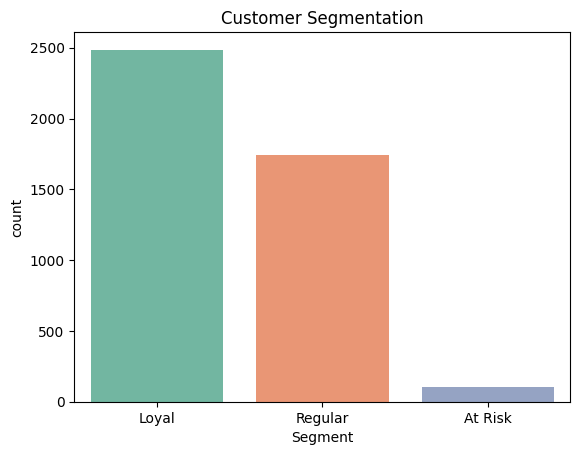

In [25]:
sns.countplot(data=rfm,x="Segment",palette='Set2',hue='Segment',legend=False)
plt.title("Customer Segmentation")
plt.show()

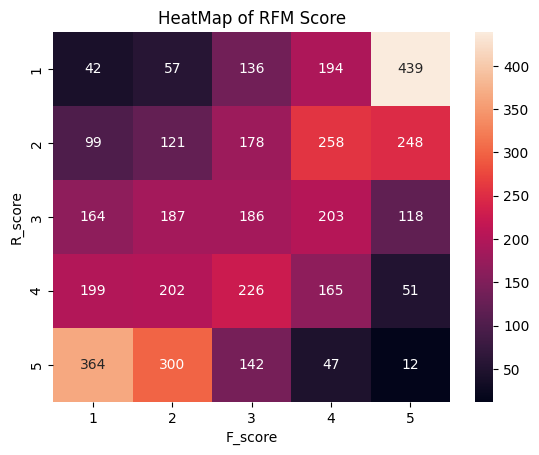

In [30]:
rfm_group=rfm.groupby(["R_score","F_score"], observed=False)["CustomerID"].count().unstack(fill_value=0)
sns.heatmap(rfm_group,annot=True, fmt="d")
plt.title("HeatMap of RFM Score")
plt.show()


In [36]:
rfm.to_csv("rfm_segmentaion.csv",index=False)